# EDA

### Wczytanie danych

In [2]:
import os
from pathlib import Path
from typing import Optional

data_path: Path = Path("data/CK-dataset")
labels_path: Path = data_path / Path("label/")
frames_path: Path = data_path / Path("image/")
data: dict[str, list[str]] = dict()
frames: dict[str, int] = dict()

emotion_mapper: dict[int, str] = {
    0: "neutral",
    1: "anger",
    2: "contempt",
    3: "disgust",
    4: "fear",
    5: "happy",
    6: "sadness",
    7: "surprise",
}

def get_emotion_from_clip(path: str) -> Optional[float]:
    label_files = os.listdir(path)
    assert len(label_files) <= 1
    if label_files:
        with open(os.path.join(path, label_files[0]) , "r") as file:
            value = float(file.readline())
        return value
    return None

# wczytanie emocji poszczególnych osób

for person in os.listdir(labels_path):
    data[person] = []
    person_path = os.path.join(labels_path, person)
    for clip in os.listdir(person_path):
        emotion_label = get_emotion_from_clip(os.path.join(person_path, clip))
        if emotion_label is not None:
            data[person].append(emotion_label)

# zliczanie klatek dla poszczególnych osób

for person in os.listdir(frames_path):
    person_path = os.path.join(frames_path, person)
    frames[person] = 0
    for clip in os.listdir(person_path):
        if clip.startswith("0"):
            frames[person] += len(
                os.listdir(os.path.join(person_path, clip))
            )


data["S096"], frames["S096"]

([5.0, 7.0, 3.0], 36)

### Rozkład emocji w zbiorze danych

In [3]:
# lista wszystkich wykrytych emocji

flat_data = sum(list(data.values()), [])
len(flat_data)

327

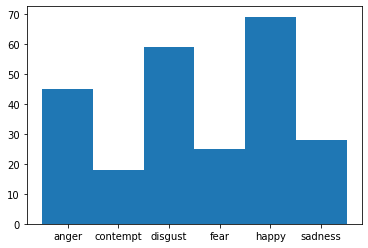

In [4]:
import matplotlib.pyplot as plt
import numpy as np

_ = plt.hist(sorted([emotion_mapper[x] for x in flat_data]), bins=np.arange(len(set(flat_data)))-0.5)

### Rozkład liczby klatek dla poszególnych osób

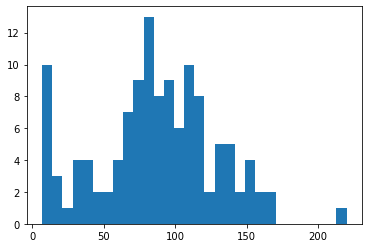

In [5]:
flat_frames: list[int] = frames.values()
_ = plt.hist(flat_frames, bins=30)

In [6]:
print(f"Maksymalna liczba klatek na osobę: {max(flat_frames)}, minimalna liczba klatek na osobę: {min(flat_frames)}.")

Maksymalna liczba klatek na osobę: 220, minimalna liczba klatek na osobę: 7.


### Przygotownie zbioru danych:

Przygotowując zbiór danych założyliśmy podział względem osób, a nie klipów, czyli jeśli ujęcia danej osoby znajdują się w zbiorze treningowym, to nie wystąpią już w walidacyjnym (i na odwrót). Takie złożenie powinno naszym zdaniem dać rzetelniejsze wyniki. 


In [7]:
import json
from src.dataset.ck_dataset import make_dataset


split_path = Path("split.json")
with split_path.open() as file:
    split_dict = json.load(file)

train_dataset = make_dataset(root_path=data_path, people_names=split_dict["train"])
val_dataset = make_dataset(root_path=data_path, people_names=split_dict["val"])

total = len(train_dataset) + len(val_dataset)

print(
    f"Podział train/val: "
    f"{len(train_dataset)}/{len(val_dataset)} | " 
    f"{len(train_dataset)/total:.2f}/{len(val_dataset)/total:.2f}"
)

Loading dataset: 100%|██████████| 484/484 [00:00<00:00, 47144.52it/s]

Podział train/val: 1148/484 | 0.70/0.30


### Rozkład emocji względem klatek w przygotowanym zbiorze danych:

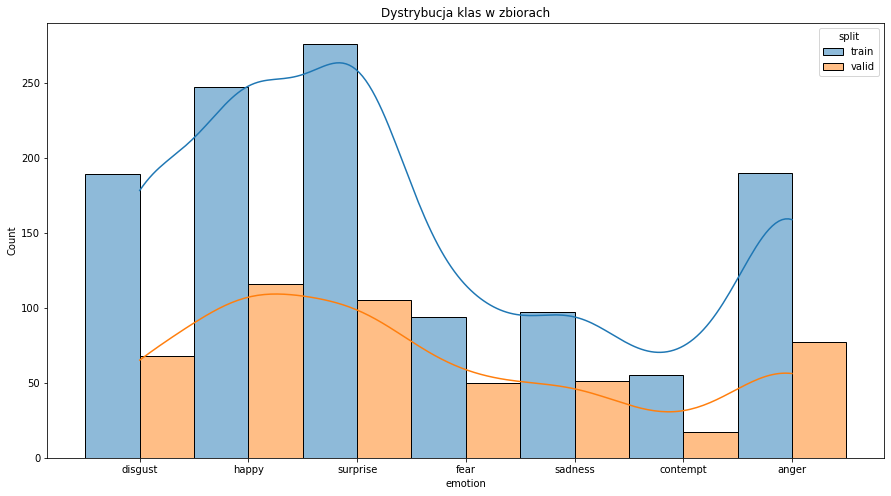

In [24]:
import torch
import pandas as pd

from collections import defaultdict
from typing import TYPE_CHECKING
import seaborn as sns


def plot_emotions_distribution(train_dataset, val_dataset):

    data = []

    for sample in train_dataset:
        data.append(("train", emotion_mapper[sample["label"].item()]))

    for sample in val_dataset:
        data.append(("valid", emotion_mapper[sample["label"].item()]))

    df = pd.DataFrame(data, columns=["split", "emotion"])

    fig, ax = plt.subplots(figsize=(15, 8))
    ax.set_title("Dystrybucja klas w zbiorach")
    sns.histplot(data=df, x="emotion", hue="split", kde=True, multiple="dodge", ax=ax)

plot_emotions_distribution(train_dataset, val_dataset)

## Wizualizacja siatek

In [36]:
import pyvista as pv

for i, sample in enumerate(train_dataset):
    if sample["label"].item() == 2:
        print(i)


69
70
71
130
131
132
133
199
200
201
202
203
204
205
393
394
395
396
577
578
579
585
586
587
588
724
725
726
782
783
784
811
812
813
814
815
816
817
875
876
877
878
963
964
965
966
999
1000
1001
1016
1017
1018
1019
1020
1021
